In [20]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from imutils import paths
from random import shuffle
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.image as mpimg
import os.path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from matplotlib.pyplot import imshow
from PIL import Image
import matplotlib
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage

In [21]:
DATASET_PATH = r"D:\Projects\PyCharmProjects\watsonTraining\images_google\101_ObjectCategories\101_ObjectCategories"
# Increase the number if you want to scan all the repo
MAX_IMAGES_TO_SEARCH_FROM_REPO = 1000
PICKLED_MODEL_FILENAME = 'model.sav'
QUERY_IMAGE_PATH = r"D:\Projects\PyCharmProjects\watsonTraining\images_google\gun.jpg"
IMAGE_SIZE = (224, 224)
NUMBER_OF_RESULTS = 3

In [22]:
def load_model():
    """
    Loads the pre-trained model.
    :return: the model
    """
    if not os.path.exists(PICKLED_MODEL_FILENAME):
        # save the model to disk
        print("Loading model and dumping it to the disk")
        model = VGG16(weights='imagenet', include_top=False)
        pickle.dump(model, open(PICKLED_MODEL_FILENAME, 'wb'))
        return model
    else:
        # load the model from disk if already exists.
        print("Loading model from the disk")
        model = pickle.load(open(PICKLED_MODEL_FILENAME, 'rb'))
        return model

In [23]:
def img_to_data(img_path):
    """
    Converts img to data(array)
    :param img_path: the path of the input image.
    :return: data of an image after preprocess.
    """
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    return img_data

In [24]:
def img_to_features_vector(img_data, model):
    """
    Feeding the image data to the model.
    :param img_data: the data of an image.
    :return: the vector the model outputs.
    """
    vgg16_feature = model.predict(img_data)
    vgg16_feature = np.array(vgg16_feature)
    return vgg16_feature.flatten()

In [26]:
TSNE_IMG_FILENAME = "example-tSNE-caltech101.png"
DISTANCE_METRIC = 'euclidean'
FEATURE_DIMENSION_NUMBER = 100


def generate_tsne(img_paths, img_vector_features):
    # Perform PCA over the features
    num_feature_dimensions = FEATURE_DIMENSION_NUMBER  # Set the number of features
    pca = PCA(n_components=num_feature_dimensions)
    pca.fit(img_vector_features)
    feature_list_compressed = pca.transform(img_vector_features)

    # For speed and clarity, we'll analyze about first half of the dataset.
    selected_features = feature_list_compressed[:]
    selected_filenames = img_vector_features[:]

    tsne_results = TSNE(n_components=2, verbose=1, metric=DISTANCE_METRIC).fit_transform(selected_features)

    X = np.array(feature_list_compressed)
    tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

    tx, ty = tsne[:, 0], tsne[:, 1]
    tx = (tx - np.min(tx)) / (np.max(tx) - np.min(tx))
    ty = (ty - np.min(ty)) / (np.max(ty) - np.min(ty))

    width = 4000
    height = 3000
    max_dim = 100

    full_image = Image.new('RGBA', (width, height))
    for img, x, y in zip(img_paths, tx, ty):
        tile = Image.open(img)
        rs = max(1, tile.width / max_dim, tile.height / max_dim)
        tile = tile.resize((int(tile.width / rs), int(tile.height / rs)), Image.ANTIALIAS)
        full_image.paste(tile, (int((width - max_dim) * x), int((height - max_dim) * y)), mask=tile.convert('RGBA'))

    matplotlib.pyplot.figure(figsize=(16, 12))
    imshow(full_image)
    try:
        matplotlib.pyplot.show(full_image)
    except:
        pass
    full_image.save(TSNE_IMG_FILENAME)

Loading model from the disk


D:\Program Files (x86)\Microsoft Visual Studio\Shared\Python36_64\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:04<00:00,  5.43it/s]


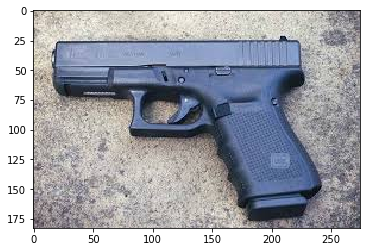

D:\Projects\PyCharmProjects\watsonTraining\images_google\101_ObjectCategories\101_ObjectCategories\revolver\image_0034.jpg


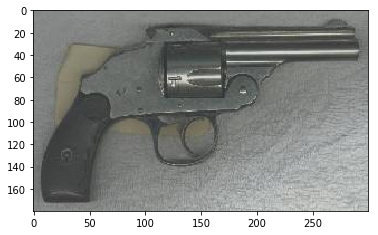

D:\Projects\PyCharmProjects\watsonTraining\images_google\101_ObjectCategories\101_ObjectCategories\revolver\image_0077.jpg


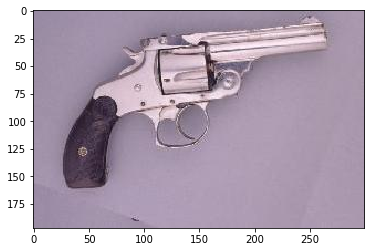

D:\Projects\PyCharmProjects\watsonTraining\images_google\101_ObjectCategories\101_ObjectCategories\revolver\image_0038.jpg


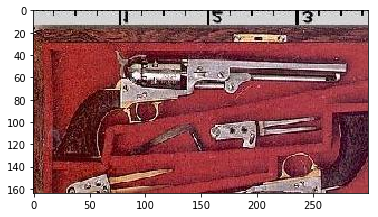

Generating TSNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.006s...
[t-SNE] Computed neighbors for 1000 samples in 0.278s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 207.421512
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.348801
[t-SNE] KL divergence after 1000 iterations: 0.936403
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.005s...
[t-SNE] Computed neighbors for 1000 samples in 0.265s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 207.421512
[t-SNE] Computed conditional probabilities in 0.114s
[t-SNE] Iteration 50: error = 69.0083084, gradient norm = 0.2465924 (50 iterations in 1.084s)
[t-SNE] Iteration 100: error = 68.9161835, gradient norm = 0.2456783 (50 iterations in 0.957s)
[t-SNE] Iteration 150: error = 69.2334366, gradient norm = 0.2547033 (50 iterations in 0.922s)
[t-SNE] Iteration 200: error = 69.28

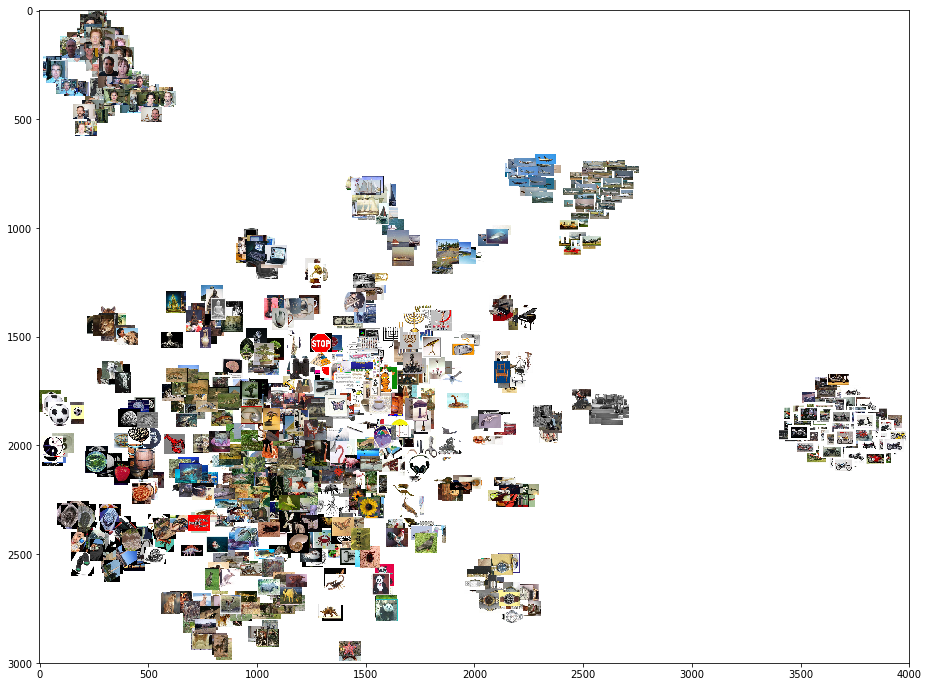

In [27]:
def main(query_image_path=QUERY_IMAGE_PATH, dataset_path=DATASET_PATH, to_generate_tsne=True):
    model = load_model()
    image_paths = list(paths.list_images(dataset_path))
    shuffle(image_paths)
    img_paths = image_paths[:MAX_IMAGES_TO_SEARCH_FROM_REPO]
    img_vector_features = []
    for img_path in tqdm(img_paths):
        # convert image to data in order to enable to feed the image to the model.
        img_data = img_to_data(img_path)
        # get from the model the features vector returned from the vgg16 model.
        img_vector_features.append(img_to_features_vector(img_data, model))

    query_img_data = img_to_data(query_image_path)
    query_feature = img_to_features_vector(query_img_data, model)

    # Numbers of similar images that we want to show
    nbrs = NearestNeighbors(n_neighbors=NUMBER_OF_RESULTS, metric="cosine").fit(img_vector_features)

    distances, indices = nbrs.kneighbors([query_feature])
    similar_image_indices = indices.reshape(-1)
    img = mpimg.imread(QUERY_IMAGE_PATH)
    imgplot = plt.imshow(img)
    plt.show()
    for idx in similar_image_indices:
        print(img_paths[idx])
        img = mpimg.imread(img_paths[idx])
        imgplot = plt.imshow(img)
        plt.show()

    if to_generate_tsne:
        print("Generating TSNE...")
        generate_tsne(img_paths, img_vector_features)
        
main()